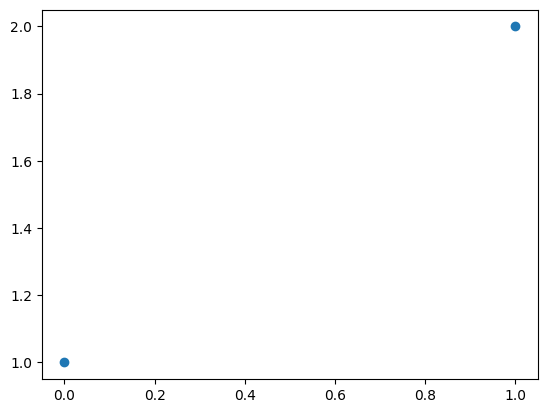

In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

In [15]:
importlib.reload(kgs)
data=kgs.load_all_train_data(validation_only=True)
print(len(data))
for d in data:
    d.check_constraints()
import seis_nn
model = seis_nn.default_pretrained
model.batch_size = 1
data = model.infer(data[::5])

5000


Importing cache brendan: 100%|████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.59it/s]


styleB not active yet


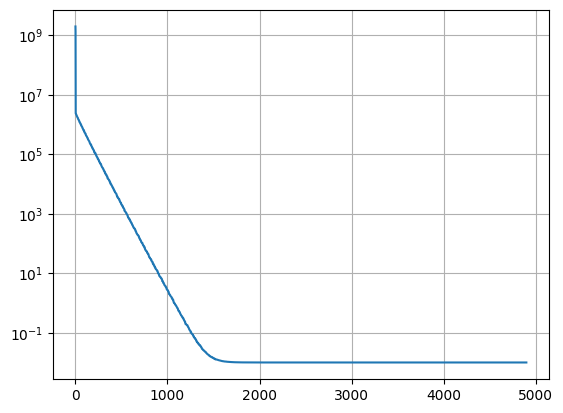

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:05<00:00,  1.50it/s]


In [16]:
vals_not = []
vals_styleA = []
vals_styleB = []
import seis_prior
import seis_model
prior = seis_model.default_model().models[1].model_Style_B.prior
prior.transform = False
prior.prepped = False
prior.prep()
from tqdm import tqdm
import cupy as cp
for d in tqdm(data):
    d.load_to_memory()
    d = model.infer([d])[0]
    d.velocity_guess.to_cupy()
    x = d.velocity_guess.to_vector()        
    kpi = np.log(cp.asnumpy(x[:-1,:].T@(prior.P)@x[:-1,:])[0,0])
    #kpi = cp.asnumpy(kgs.rms(d.seismogram.data[0,...] - cp.flip(d.seismogram.data[4,...],axis=1)))
    if 'Style_A' in d.family:
        vals_styleA.append(kpi)
    elif 'Style_B' in d.family:
        vals_styleB.append(kpi)
    else:
        vals_not .append(kpi)
        if kpi<1e-4:
            plt.figure()
            plt.imshow(cp.asnumpy(d.velocity.data))
            plt.title(d.family+' '+str(kpi))
            plt.pause(0.001)
    d.unload()

(3.8083635283685284, 5.7478671897512665, 7.909737523741001)

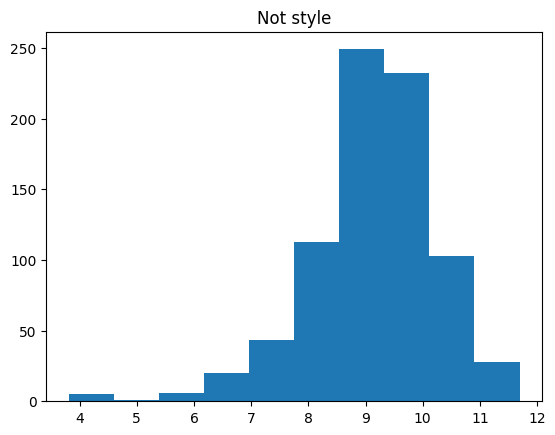

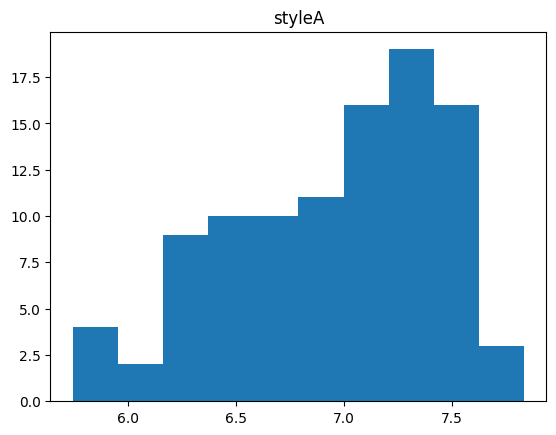

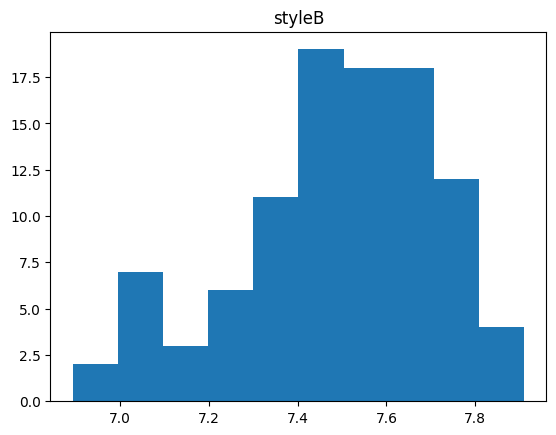

In [17]:
plt.figure()
plt.hist(vals_not)
plt.title('Not style')
plt.figure()
plt.hist(vals_styleA)
plt.title('styleA')
plt.figure()
plt.hist(vals_styleB)
plt.title('styleB')
np.min(vals_not), np.min(vals_styleA), np.max(vals_styleB)